In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [25]:
from __future__ import print_function
import numpy as np

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False
    


In [1]:
class Dataset(BaseDataset):

    def __init__(self, num_data_points = 100, num_clusters= 1 , cluster_std = 0.1):
        
        self.clusters = num_clusters
        centers = [[np.random.randn(),np.random.randn()] for i in range(num_clusters) ]
        self.X,self.y = gen_dataset.make_blobs(n_samples=num_data_points,random_state=1,centers=centers,cluster_std=cluster_std)
 
        
    def __getitem__(self, i):
        x_data = torch.Tensor(self.X[i])
        if self.clusters > 2:
            y_data =  torch.Tensor([1 if self.y[i] == j else 0 for j in range(self.clusters)]).long()
        else:
            y_data = torch.Tensor([self.y[i]])
#         print(y_data,self.y[i])
        return x_data,y_data
    
    def get_all_data(self):
        return self.X,self.y
    
    def visualize(self):
        plt.figure()
        for i in range(self.clusters):
            plt.scatter(self.X[self.y==i,0],self.X[self.y==i,1] )
        plt.show()
    
    def __len__(self):
        return len(self.y)

NameError: name 'BaseDataset' is not defined

In [6]:
def to_viewable_image(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array( (0.5,0.5,0.5)) + np.array( (0.5,0.5,0.5))
    image = image.clip(0,1)
    return image

In [2]:
%reset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets as gen_dataset

from torchvision import datasets,transforms


torch.manual_seed(1)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                                ])
training_dataset = datasets.MNIST(root = './data',train =True,download =True,transform=transform)
validation_dataset = datasets.MNIST(root = './data',train =False,download =True,transform=transform)

In [43]:
class my_model(nn.Module):
    def __init__(self, input_size = 1 , output_size = 1, num_layers = 1, width = 1):
        super().__init__()
        self.input_layer = nn.Linear(input_size,width)
        self.hidden_layer = nn.Linear(width,width)
        self.output_layer = nn.Linear(width,output_size)
    
        self.num_layers = num_layers
        
    def forward(self,x):
        x = F.relu(self.input_layer(x))
        
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layer(x))
            
        pred = self.output_layer(x)
        return pred
    
    def predict(self,x):
        pred = self.forward(x)
        return np.argmax(pred.detach().numpy(),axis=1)
    
    
    
    
class my_cnn_model(nn.Module):
    def __init__(self, input_channels = 1 , classses = 10,fc_neurons = 500):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 20, 5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.max_pool = nn.MaxPool2d(2,2)
        self.FC = nn.Linear(800,fc_neurons)
        self.head = nn.Linear(fc_neurons,classses)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x):
       
       
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
    
        x =x.view(-1,800)
        
        x = F.relu(self.FC(x))
        x= self.dropout(x)
        pred = self.head(x)
        return pred
    
    def conv_output_size(self,image_size, kernal_size, padding = 0  , stride = 1):
        w = image_size
        k = kernal_size
        p = padding
        s = stride
        return int(((w-k+2*p)/s)+1)
    
    def predict(self,x):
        pred = self.forward(x)
        return np.argmax(pred.cpu().detach().numpy(),axis=1)

In [8]:
batch_size = 200
training_loader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(validation_dataset,batch_size=batch_size,shuffle=False)


In [23]:
cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

(28, 28, 3)

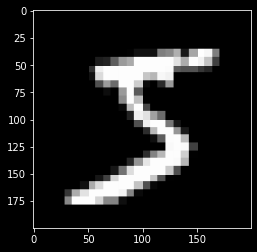

In [31]:

img = cv2.resize( to_viewable_image(training_dataset[0][0]) , (200,200), interpolation = cv2.INTER_AREA)
 
plt.imshow(img) 



In [19]:
cv2.destroyAllWindows()

In [6]:
X,y = iter(training_loader).next()
model = my_cnn_model()
model.forward(X).shape
# X.shape[-1]

torch.Size([200, 10])

In [44]:
%matplotlib qt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = my_model(input_size = 28*28 ,output_size = 10, num_layers = 2, width = 100)
model = my_cnn_model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)

epochs = 10
training_loss = []
training_accuracy = []

validation_accuracy = []
validation_loss =[]

for i in range(epochs):
    
    training_running_loss = 0.0
    training_running_accuracy =0.0
    
    validation_running_loss = 0.0
    validation_running_accuracy =0.0
    
    for X,y in training_loader:
        
        X,y = X.to(device),y.to(device) 
#         X = X.view(X.shape[0],-1)
        y_pred = model(X)
        loss = criterion(y_pred,y)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_running_loss += loss.item()
        
        predicted_label = np.argmax(y_pred.cpu().detach(),1)
        training_running_accuracy += sum(predicted_label == y.cpu().data)
    else:
        with torch.no_grad():
            for val_X,val_y in validation_loader:

                val_X,val_y = val_X.to(device),val_y.to(device) 
#                 val_X = val_X.view(val_X.shape[0],-1)
                y_pred = model(val_X)
                loss = criterion(y_pred,val_y)
                
                validation_running_loss += loss.item()
                predicted_label = np.argmax(y_pred.cpu().detach(),1)
                validation_running_accuracy += sum(predicted_label == val_y.cpu().data)
                
                
            
        val_epoch_loss = validation_running_loss/len(validation_loader)
        val_epoch_accuracy = (validation_running_accuracy.float()/len(validation_loader))/batch_size
        
        epoch_loss = training_running_loss/len(training_loader)
        epoch_accuracy = (training_running_accuracy.float()/len(training_loader))/batch_size
        
        print(f'epoch:{i} training loss:{ round(epoch_loss,4) }  training accuracy:{ round(epoch_accuracy.item(),4) } val loss:{ round(val_epoch_loss,4) }  val accuracy:{ round(val_epoch_accuracy.item(),4) }')
        
        training_loss.append(epoch_loss)
        training_accuracy.append(epoch_accuracy.item())
        
        validation_loss.append(val_epoch_loss)
        validation_accuracy.append(val_epoch_accuracy.item())
    
 
    

epoch:0 training loss:0.2511  training accuracy:0.9243 val loss:0.0689  val accuracy:0.9784
epoch:1 training loss:0.0636  training accuracy:0.9806 val loss:0.0475  val accuracy:0.9839
epoch:2 training loss:0.0433  training accuracy:0.9862 val loss:0.0447  val accuracy:0.9859
epoch:3 training loss:0.0353  training accuracy:0.9892 val loss:0.0407  val accuracy:0.9878
epoch:4 training loss:0.0294  training accuracy:0.9907 val loss:0.037  val accuracy:0.9897
epoch:5 training loss:0.0247  training accuracy:0.9923 val loss:0.0347  val accuracy:0.989
epoch:6 training loss:0.0229  training accuracy:0.9927 val loss:0.0377  val accuracy:0.9885
epoch:7 training loss:0.0192  training accuracy:0.994 val loss:0.0304  val accuracy:0.9912
epoch:8 training loss:0.0169  training accuracy:0.9945 val loss:0.0343  val accuracy:0.9909
epoch:9 training loss:0.0164  training accuracy:0.9947 val loss:0.0311  val accuracy:0.9914


In [45]:
fig =  plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(training_loss , label = 'train')
ax1.plot(validation_loss , label = 'val')
ax1.set_title('loss')
ax1.legend()
ax2 = fig.add_subplot(2,1,2)
ax2.plot(training_accuracy , label = 'train')
ax2.plot(validation_accuracy , label = 'val')
ax2.set_title('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('wDropout.jpg')

In [41]:
import cv2
import numpy as np 
from PIL import Image

drawing = False # true if mouse is pressed
pt1_x , pt1_y = None , None


def show(img, title="", time=-1):
    cv2.imshow(title, img)
    key = cv2.waitKey(time)
    return key

def draw_digit(model):
    # mouse callback function
    def line_drawing(event,x,y,flags,param):
        global pt1_x,pt1_y,drawing

        if event==cv2.EVENT_LBUTTONDOWN:
            drawing=True
            pt1_x,pt1_y=x,y

        elif event==cv2.EVENT_MOUSEMOVE:
            if drawing==True:
                cv2.line(img,(pt1_x,pt1_y),(x,y),color=(255,255,255),thickness=20)
                pt1_x,pt1_y=x,y
        elif event==cv2.EVENT_LBUTTONUP:
            drawing=False
            cv2.line(img,(pt1_x,pt1_y),(x,y),color=(255,255,255),thickness=20)        


    img = np.zeros((512,512,3), np.uint8)
    cv2.namedWindow('test draw')
    cv2.setMouseCallback('test draw',line_drawing)

    whil1:
        key = show(img,'test draw',1)
        if key == 13:
            break
    cv2.destroyAllWindows()
    
    
    
    digit = digit.convert('1')
    digit = transform(digit)
    # digit = digit.view(digit.shape[0],-1)
    digit = digit.unsqueeze(0).to(device)
    y_pred = model(digit)
    predicted_label = np.argmax(y_pred.cpu().detach(),1)
    
    
    return img

digit  = Image.fromarray(draw_digit())
digit = digit.convert('1')
digit = transform(digit)
# digit = digit.view(digit.shape[0],-1)
digit = digit.unsqueeze(0).to(device)
y_pred = model(digit)
predicted_label = np.argmax(y_pred.cpu().detach(),1)
predicted_label

tensor([8])

In [33]:
len(training_loader.dataset)

60000

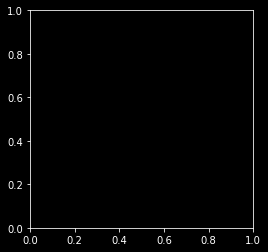

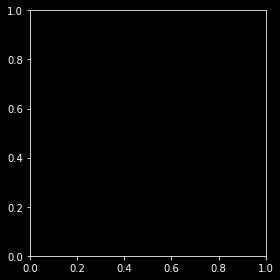

In [2]:
import PySimpleGUI as sg


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import numpy as np
from torchvision import datasets,transforms

from matplotlib.ticker import FormatStrFormatter

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, FigureCanvasAgg
import matplotlib.pyplot as plt
import inspect
import threading
import queue
import matplotlib.cm as cm

import cv2
from PIL import Image


torch.manual_seed(1)
plt.style.use('dark_background')
sg.theme('Black')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                                ])
training_dataset = datasets.MNIST(root = './data',train =True,download =True,transform=transform)
validation_dataset = datasets.MNIST(root = './data',train =False,download =True,transform=transform)
    

drawing = False # true if mouse is pressed
pt1_x , pt1_y = None , None


def preview_data():
    for i in range(0,5):
        j = np.random.randint(0,1000)
        img = cv2.resize( to_viewable_image(training_dataset[j][0]) , (200,200), interpolation = cv2.INTER_AREA)
        cv2.imshow('', img)
        cv2.waitKey(1000)
    
    cv2.destroyAllWindows()

def to_viewable_image(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array( (0.5,0.5,0.5)) + np.array( (0.5,0.5,0.5))
    image = image.clip(0,1)
    return image
    
def show(img, title="", time=-1):
    cv2.imshow(title, img)
    key = cv2.waitKey(time)
    return key

def draw_digit(model):
    # mouse callback function
    def line_drawing(event,x,y,flags,param):
        global pt1_x,pt1_y,drawing

        if event==cv2.EVENT_LBUTTONDOWN:
            drawing=True
            pt1_x,pt1_y=x,y

        elif event==cv2.EVENT_MOUSEMOVE:
            if drawing==True:
                cv2.line(img,(pt1_x,pt1_y),(x,y),color=(255,255,255),thickness=20)
                pt1_x,pt1_y=x,y
        elif event==cv2.EVENT_LBUTTONUP:
            drawing=False
            cv2.line(img,(pt1_x,pt1_y),(x,y),color=(255,255,255),thickness=20)        


    img = np.zeros((512,512,3), np.uint8)
    cv2.namedWindow('Hand Written Digit Classifier:Press enter to classify')
    cv2.setMouseCallback('Hand Written Digit Classifier:Press enter to classify',line_drawing)

    while 1:
        key = show(img,'Hand Written Digit Classifier:Press enter to classify',1)
        if key == 13:
            break
    cv2.destroyAllWindows()
    
    
    img = Image.fromarray(img)
    img = img.convert('1')
    img = transform(img)
    img = img.unsqueeze(0).to(device)
    y_pred = model(img)
    predicted_label = np.argmax(y_pred.cpu().detach(),1)
    pads = '*'*10
    sg.popup(f'{pads}You drew:{predicted_label.numpy()[0]}{pads}',background_color='yellow',text_color='black',title = 'Prediction' )
    
    return 





class my_cnn_model(nn.Module):
    def __init__(self, input_channels = 1 , classses = 10,fc_neurons = 500,dropout_on = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 20, 5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.max_pool = nn.MaxPool2d(2,2)
        self.FC = nn.Linear(800,fc_neurons)
        self.head = nn.Linear(fc_neurons,classses)
        self.dropout = nn.Dropout(0.5)
        self.dropout_on = dropout_on
        
    def forward(self,x):
       
       
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
    
        x =x.view(-1,800)
        
        x = F.relu(self.FC(x))
        
        if self.dropout_on:
            x= self.dropout(x)
        
        pred = self.head(x)
        return pred
    
    def conv_output_size(self,image_size, kernal_size, padding = 0  , stride = 1):
        w = image_size
        k = kernal_size
        p = padding
        s = stride
        return int(((w-k+2*p)/s)+1)
    
    def predict(self,x):
        pred = self.forward(x)
        return np.argmax(pred.cpu().detach().numpy(),axis=1)
    


try:
    model = my_cnn_model().to(device)
except:
    device = torch.device('cpu')
    model = my_cnn_model().to(device)   
    
    
def draw_figure(canvas, figure, loc=(0, 0)):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

def get_default_args(func):
    signature = inspect.signature(func)
    return {
        k: v.default
        for k, v in signature.parameters.items()
        if (v.default is not inspect.Parameter.empty) and (k != 'lr')
    }


def train_network(net_fig_queue,stop_training_queue ):
 
    

    neurons = int(values['neuron_slider'] )
    dropout_on = values['dropout']
    learning_rate = float(values['lr_slider']) 
    epochs = int(values['epoch_slider'])
    batch_size = int(values['batch_slider'])
    
    training_loader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
    validation_loader = DataLoader(validation_dataset,batch_size=batch_size,shuffle=False)
    global model
    model = my_cnn_model(dropout_on = dropout_on).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)

    training_loss = []
    training_accuracy = []

    validation_accuracy = []
    validation_loss =[]
    
    train_inc = (len(training_loader.dataset)/batch_size)//100
    val_inc = (len(validation_loader.dataset)/batch_size)//100
    for i in range(epochs):

        training_running_loss = 0.0
        training_running_accuracy =0.0

        validation_running_loss = 0.0
        validation_running_accuracy =0.0
        train_count = 0
       
        for X,y in training_loader:

            X,y = X.to(device),y.to(device) 
    #         X = X.view(X.shape[0],-1)
            y_pred = model(X)
            loss = criterion(y_pred,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            try:
                train_terminate = stop_training_queue.get_nowait()
            except queue.Empty:
                train_terminate = None
            finally:
                if train_terminate:
                    return 
             
            training_running_loss += loss.item()

            predicted_label = np.argmax(y_pred.cpu().detach(),1)
            training_running_accuracy += sum(predicted_label == y.cpu().data)
#             Progress bar training
            
           
            if train_count % train_inc == 0:    
                window['train_bar'].UpdateBar(train_count//train_inc)
            train_count += 1
            
            
        else:
            print(train_count)
            with torch.no_grad():
                val_count = 0
                for val_X,val_y in validation_loader:
                    
                    try:
                        train_terminate = stop_training_queue.get_nowait()
                    except queue.Empty:
                        train_terminate = None
                    finally:
                        if train_terminate:
                            return
                    
                    
                    val_X,val_y = val_X.to(device),val_y.to(device) 
    #                 val_X = val_X.view(val_X.shape[0],-1)
                    y_pred = model(val_X)
                    loss = criterion(y_pred,val_y)

                    validation_running_loss += loss.item()
                    predicted_label = np.argmax(y_pred.cpu().detach(),1)
                    validation_running_accuracy += sum(predicted_label == val_y.cpu().data)
                    if val_count % val_inc == 0:
                        window['val_bar'].UpdateBar(val_count//val_inc)
                    val_count += 1
# progress bar validating


            val_epoch_loss = validation_running_loss/len(validation_loader)
            val_epoch_accuracy = (validation_running_accuracy.float()/len(validation_loader))/batch_size

            epoch_loss = training_running_loss/len(training_loader)
            epoch_accuracy = (training_running_accuracy.float()/len(training_loader))/batch_size

            print(f'epoch:{i} training loss:{ round(epoch_loss,4) }  training accuracy:{ round(epoch_accuracy.item(),4) } val loss:{ round(val_epoch_loss,4) }  val accuracy:{ round(val_epoch_accuracy.item(),4) }')
            
            window['epoch_bar'].UpdateBar((i+1)*(100/epochs))
            
            training_loss.append(epoch_loss)
            training_accuracy.append(epoch_accuracy.item())

            validation_loss.append(val_epoch_loss)
            validation_accuracy.append(val_epoch_accuracy.item())
            
            net_plot.cla()
            net_plot.set_title('Loss')
            net_plot.plot(training_loss,label = 'train')
            net_plot.plot(validation_loss,label = 'Val')
            net_plot.legend()
            loss_plot.cla()
            loss_plot.set_title('Accuracy')
            loss_plot.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            loss_plot.plot(training_accuracy , label = 'train')
            loss_plot.plot(validation_accuracy, label = 'val' )
            loss_plot.legend()
            
            net_fig_queue.put(1)
            
        

    window['stop_training'].update(disabled = True)




text_len= len('GOOEY Neural Nets: Convolutional Neural Networks')
data_frame_text_len = len('Number of clusters:')
model_frame_text_len = len('Number of neurons in FC layer:')
bar_format = len('Training:')

optimizer_list = [optimizer for optimizer in  dir(torch.optim) if (optimizer not in ['Optimizer','lr_scheduler']) and ('__' not in optimizer  ) ]
max_optim_len = max([len(string) for string in optimizer_list]) + 1
optimizer_parameter_dict = {optimizer:get_default_args(getattr(torch.optim,optimizer)) for optimizer in optimizer_list }
initial_optim_params_list = list( optimizer_parameter_dict[optimizer_list[0]] )
init_params_dict = optimizer_parameter_dict[optimizer_list[0]]
max_optim_len = max([len(string) for string in optimizer_list])


layout = [

    [sg.Text('GOOEY Neural Nets: Convolutional Neural Networks', size=(text_len, 1), justification='center', font=("Arial", 25), relief=sg.RELIEF_RIDGE)],
    
    [sg.Frame(layout = [
    
        [sg.Button('Preview Data')],
       
    ], relief = sg.RELIEF_SUNKEN , title = 'DATA'  )   ],
    
    [sg.Frame(layout = [
    
        [sg.Text('Number of neurons in FC layer:',size = (model_frame_text_len,1) ),sg.Slider(default_value = 500, range=(100, 1000), size=(60, 20), orientation='h', key='neuron_slider')     ],
        [sg.Text('activate dropout:',size = (model_frame_text_len,1)),sg.Checkbox('',key='dropout')],
        [sg.Text('Batch Size:',size = (model_frame_text_len,1)) ,sg.Slider(default_value = 32,range=(32, 500),resolution=1, size=(60, 20), orientation='h', key='batch_slider')    ],
        [sg.Text('Learning Rate:',size = (model_frame_text_len,1)) ,sg.Slider(default_value = 0.01,range=(0, 10),resolution=0.01, size=(60, 20), orientation='h', key='lr_slider')    ],
        [sg.Text('Epochs:',size = (model_frame_text_len,1)),sg.Slider(default_value = 15,range=(0, 100),resolution=1, size=(60, 20), orientation='h', key='epoch_slider')     ],
        [sg.Text('Optimizers:',size = (model_frame_text_len,1)),sg.DropDown(values = optimizer_list , default_value = optimizer_list[0],enable_events = True, key = 'optimizer',size = (max_optim_len,1))],
        [sg.Text('Optimizer parameters:',size = (model_frame_text_len,1)), sg.DropDown(values = initial_optim_params_list, default_value = initial_optim_params_list[0], enable_events = True  , key ='optimizer_params')],
        [sg.Text('parameter value:',size = (model_frame_text_len,1)),sg.Input( init_params_dict[ initial_optim_params_list[0]],tooltip = 'Enter in format shown', key = 'param_value',size = (10,1)) , sg.Text(type(init_params_dict[ initial_optim_params_list[0]]),key='param_type' ) , sg.Button('Update',key = 'update') ,sg.Button('reset all',key = 'reset')]
        
        
    
    ], relief = sg.RELIEF_SUNKEN , title = 'MODEL'  )   ],
    
    [sg.Button('Start Training',key = 'train_net'),sg.Button('Stop Training' , disabled = True, key = 'stop_training') ],
    [sg.Text('Training:',size=(bar_format,1)),sg.ProgressBar(100, orientation='h', size=(20, 20), key='train_bar'),sg.Text('Validating:'),sg.ProgressBar(100, orientation='h', size=(20, 20), key='val_bar')],
    [sg.Text('Epochs:',size=(bar_format,1)),sg.ProgressBar(100, orientation='h', size=(20, 20), key='epoch_bar')],
    [sg.Canvas( size = (100,100) , key = 'net_canvas' ),sg.Canvas( size = (100,100) , key = 'loss_canvas' )],
    [sg.Button('Classify My Hand Written Digits',key = 'test')],
    
    [sg.Button('Exit')]
]      

window = sg.Window('GOOEY Neural Nets', layout , finalize = True) 

# net canvas
net_canvas_elem = window['net_canvas']
net_canvas = net_canvas_elem.TKCanvas

net_fig = plt.figure(figsize=(4,4))
net_plot = net_fig.add_subplot(111)
# net_plot.grid()
net_fig_agg = draw_figure(net_canvas, net_fig)

# loss canvas
loss_canvas_elem = window['loss_canvas']
loss_canvas = loss_canvas_elem.TKCanvas

loss_fig = plt.figure(figsize=(4,4))
loss_plot = loss_fig.add_subplot(111)
# loss_plot.grid()
loss_fig_agg = draw_figure(loss_canvas, loss_fig)

plt.tight_layout()

draw_signal = queue.Queue()
stop_training = queue.Queue()

# =======
 
criterion = ''
optimizer = ''
epochs = ''

losses = []

data_points = 0
data = ''
#===========
while 1:
    event, values = window.read(timeout = 100)    
    if event == 'Exit':
        stop_training.put(1)
        window.close()
        break
    elif event == 'Preview Data':
        preview_data()
        
    elif event == 'optimizer':
        
         window['optimizer_params'].update( values= list( optimizer_parameter_dict[ values['optimizer'] ] ) ) 

    elif event == 'optimizer_params':
        
        current_param_type = type(optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']])
        window['param_type'].update(current_param_type if current_param_type != int else float)
        param_value = optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']]
        window['param_value'].update( param_value if current_param_type != int else float(param_value) )
       
        
    elif event == 'update':
        current_param_type = type( optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']] )
        new_value = ''
        if current_param_type == tuple:
            indiv_type = type(optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']][0])
            if len(values['param_value'].split()) != 2:
                print('incorrect input')
            else:
                new_value = ( indiv_type(values['param_value'].split()[0]) , indiv_type(values['param_value'].split()[1]) )
                optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']] = new_value
        else:
            try:
                new_value = current_param_type(values['param_value'])
                optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']] = new_value
            except:
                print('incorrect input')
                   
    elif event == 'train_net':
        net_plot.cla()
        loss_plot.cla()
        net_fig_agg.flush_events()
        net_fig_agg.draw()
    
        loss_fig_agg.flush_events()
        loss_fig_agg.draw()
        window['train_bar'].UpdateBar(0)
        window['val_bar'].UpdateBar(0)
        window['epoch_bar'].UpdateBar(0)
        t1 = threading.Thread(target=train_network , args = (draw_signal,stop_training) , daemon = True)
        t1.start()
        window['stop_training'].update(disabled = False)
        
    elif event =='stop_training':  
        stop_training.put(1)
        window['stop_training'].update(disabled = True)
    elif event =='test':
        draw_digit(model)
    
            
    try:
        draw_status = draw_signal.get_nowait()
    except queue.Empty:
        draw_status = None
    
    if draw_status:
        
        net_fig_agg.flush_events()
        net_fig_agg.draw()
    
        loss_fig_agg.flush_events()
        loss_fig_agg.draw()
        
    